In [1]:
import numpy as np
import scipy.stats


import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt

font = {'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)

from corrts import *

In [27]:
N = 5000
n = 2500
rk= 5
r = 10**(-3)
rg_rft = []

xs = []
for i in range(N): 
    x = sample_random_process(n, r=r,dt=1)
    
    xs.append(x)
    
    rg_rft.append(estimate_roughness(x, dt=1, method='rft'))

xs = np.stack(xs, 0)

rg_rft = np.asarray(rg_rft)

print_stats = lambda rg: print(f'{rg.mean():.2e} ({rg.mean() - 1.96 * rg.std():.2e}, {(rg.mean() + 1.96 * rg.std()):.2e})')

print_stats(rg_rft)


1.05e-03 (6.84e-04, 1.42e-03)


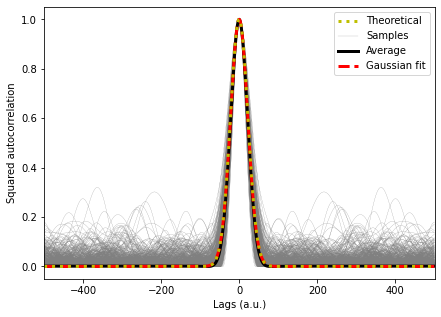

In [28]:
lags  = np.arange(0, n+1) - n//2

acf_x = acf(xs, "fft")
acf_x = np.concatenate([acf_x[:, n//2:], acf_x[:, :n//2+1]], axis=-1)

acf_th  = np.exp(-lags**2 * r)
acf_fit = np.exp(-lags[None, :]**2 * rg_rft[:, None])

nlags   = 500
ii      = np.arange(-nlags, nlags+1) + n//2
lags    = lags[ii]
acf_x   = acf_x[:, ii]
acf_th  = acf_th[ii]
acf_fit = acf_fit[:, ii]


plt.figure(figsize=(7, 5))
h1  = plt.plot(lags, acf_x[:512].T**2, 'grey', label='Samples', linewidth=0.2)

# plt.fill_between(lags, acf_fit.mean(0)-acf_fit.std(0)*1.96, acf_fit.mean(0)+acf_fit.std(0)*1.96, facecolor='r', alpha=0.2)

h2, = plt.plot(lags, acf_x.mean(0)**2, 'k', label='Average', linewidth=3)
h4, = plt.plot(lags, acf_fit.mean(0), 'r--', label='Gaussian fit', linewidth=3)
h3, = plt.plot(lags, acf_th, 'y:', label='Theoretical', linewidth=3)
plt.xlim(-nlags, nlags+1)
plt.xlabel('Lags (a.u.)')
plt.ylabel('Squared autocorrelation')
plt.legend(handles=[h3, h1[0], h2, h4])
plt.savefig(f'sq_acf_simul_rem{rk:d}.pdf')
plt.show(); 

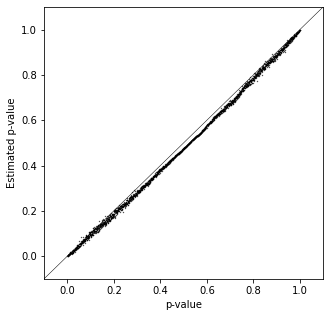

In [29]:
rs    = pearson_r(xs[:N // 2], xs[N // 2:])
edfs  = edfs_factor_rft(xs[:N // 2], xs[N // 2:])
pvals = z_pvalue(fisher_transform(rs), edfs * n, two_sided=False)
prank = 1-rank(rs) / (N//2)


plt.figure(figsize=(5,5))
plt.plot([-0.1,1.1], [-0.1,1.1], 'k', linewidth=0.5)
plt.scatter(prank, pvals, s=0.1, c='k')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.xlabel('p-value')
plt.ylabel('Estimated p-value'); 
plt.savefig(f'pval_rft_simul_rem{rk:d}.pdf')
plt.show(); 

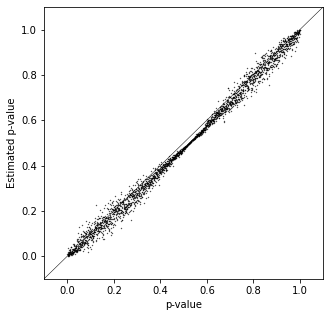

In [30]:
rs    = pearson_r(xs[:N // 2], xs[N // 2:])
edfs  = edfs_factor_quenouille(acf(xs[:N // 2], method='fft'), acf(xs[N // 2:], method='fft'))
pvals = z_pvalue(fisher_transform(rs), edfs * n, two_sided=False)
prank = 1-rank(rs) / (N//2)


plt.figure(figsize=(5,5))
plt.plot([-0.1,1.1], [-0.1,1.1], 'k', linewidth=0.5)
plt.scatter(prank, pvals, s=0.1, c='k')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.xlabel('p-value')
plt.ylabel('Estimated p-value'); 
plt.savefig(f'pval_fft_simul_rem{rk:d}.pdf')
plt.show(); 

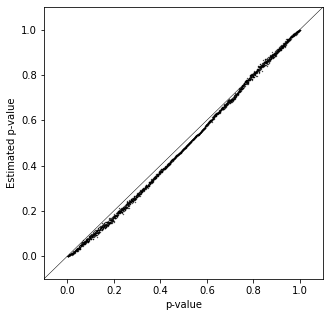

In [31]:
rs    = pearson_r(xs[:N // 2], xs[N // 2:])
edfs  = edfs_factor_quenouille(acf(xs[:N // 2], method='welch'), acf(xs[N // 2:], method='welch'))
pvals = z_pvalue(fisher_transform(rs), edfs * n, two_sided=False)
prank = 1-rank(rs) / (N//2)


plt.figure(figsize=(5,5))
plt.plot([-0.1,1.1], [-0.1,1.1], 'k', linewidth=0.5)
plt.scatter(prank, pvals, s=0.1, c='k')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.xlabel('p-value')
plt.ylabel('Estimated p-value'); 
plt.savefig(f'pval_welch_simul_rem{rk:d}.pdf')
plt.show(); 

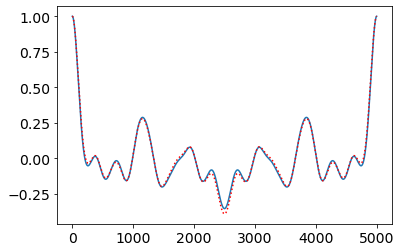

In [85]:
# plt.plot(phrndsurr(xs[0], 128).T);
plt.plot(acf(phrndsurr(xs[0], 256)).mean(0))
plt.plot(acf(xs).mean(0), 'r:')

In [ ]:
bootstrap_p(pearson_r, xs[:N // 2], xs[N // 2:], 128, return_samples=True)

In [35]:
prank

array([0.9292, 0.0708, 0.8164, ..., 0.504 , 0.2756, 0.4584])

In [66]:
rs.shape

(2500,)

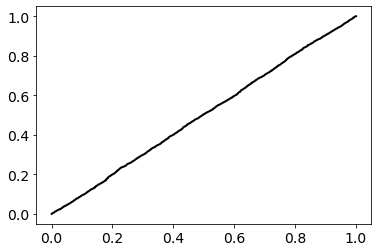

In [80]:
rs    = pearson_r(np.random.normal(size=(N//2, n)), np.random.normal(size=(N//2, n)))
pvals = z_pvalue(fisher_transform(rs), n, two_sided=False)
prank = 1-rank(rs) / (N//2)

ii = np.argsort(prank)
prank = prank[ii]
pvals = pvals[ii]

plt.plot(prank, pvals, 'k', linewidth=2)

In [ ]:
N, n = xs.shape
Bs   = 250
Nb   = max(1, N // Bs)

rs = []
for i in range(Nb):        
    ii = np.arange(Bs) + i * Bs
    for j in range(Nb): 
        jj = np.arange(Bs) + j * Bs  
        rs = pearson_r(xs[ii, None], xs[None, jj]) 


In [4]:
acf_x = acf(x, "welch")
acf_y = acf(y, "welch")

bartlett   = edfs_factor_bartlett(acf_x, acf_y)
bh         = edfs_factor_bh(acf_x, acf_y)
quenouille = edfs_factor_quenouille(acf_x, acf_y)
rft        = edfs_factor_rft(x, y)

bartlett, bh, quenouille, rft

NameError: name 'y' is not defined

In [34]:
1/np.sum(acf_x*acf_y)

0.38214083572445234

In [129]:
np.fft.fftfreq(n)

array([ 0.e+00,  1.e-05,  2.e-05, ..., -3.e-05, -2.e-05, -1.e-05])

In [197]:
Sx = np.abs(np.fft.fft(x))**2/(n)
Sy = np.abs(np.fft.fft(y))**2/(n)
Sx = np.hstack([Sx[n//2+1:], Sx[:n//2 + 1]])
Sy = np.hstack([Sy[n//2+1:], Sy[:n//2 + 1]])
Cxy = np.convolve(Sx, Sy, mode='same')
# Cxy /= 
np.fft.ifft(Cxy).mean()

(3.4553370089270176e-06+1.976445673790295e-15j)

In [192]:
np.abs(np.sqrt(2)+ 1j * np.sqrt(2))

2.0

In [150]:
f, Sx = scipy.signal.welch(x)
Sx /= Sx.sum()
_, Sy = scipy.signal.welch(y)
Sy /= Sy.sum()
1/(np.sqrt(np.mean((f)**2*2*(Sx + Sy))))

1340.5482365417322

0.0003489024679412971

In [75]:
np.sum(np.abs(np.fft.fftfreq(n))*scipy.signal.convolve(Sx, Sy, mode='same'))

2499574812.93525

In [20]:
w = estimate_roughness(x, y, dt=1e-3)

In [24]:
w.std()

0.13019945074046047

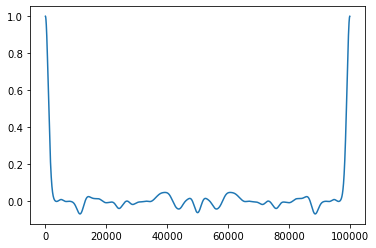

In [16]:
x = correlated_noise(100000, dt=1e-3)
y = correlated_noise(100000, dt=1e-3)
plt.plot(acf(x).T * acf(y).T)

In [2]:
t = np.linspace(0, 10, 500)
x = np.sin(2 * np.pi * t) #+ np.random.normal(0, 0.2, size=t.shape)
y = np.sin(2 * np.pi * t) #+ np.random.normal(0, 0.2, size=t.shape)

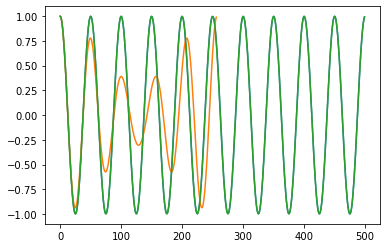

In [3]:
plt.plot(acf_sample(x))
plt.plot(acf_welch(x))
plt.plot(acf_fft(x))

In [3]:
X = x.T + np.random.normal(0, 0.2, size=(5000, t.shape[0]))
Y = y.T + np.random.normal(0, 0.2, size=(5000, t.shape[0]))

In [4]:
U, S, Vh = np.linalg.svd(cov_sample(X, 0))

In [5]:
x.shape[-1] //2 +1

251

In [13]:
n = 10
phi = np.random.uniform(0, 2*np.pi, (n, *x.shape[:-1], x.shape[-1]//2))
phi = np.concatenate([phi, phi[..., ::-1]], axis=-1)
phi.shape, phi[..., :0:-1].shape

((10, 500), (10, 499))

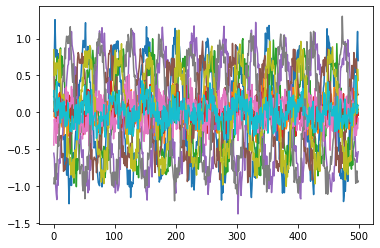

In [5]:
plt.plot(pr_surrogates(x, 10).T)

In [49]:
u = x @ U[:, ~np.isclose(S, 0)]
v = y @ U[:, ~np.isclose(S, 0)]
pearson_r(u, v)

0.9214809065418537

In [10]:
x[:0:-1], x[::-1]

(array([-0.06899988,  0.10426859, -0.43143286, -0.57889604, -0.90353375,
        -0.30291666, -0.67479618, -0.60546553, -1.23497273, -1.0653999 ,
        -0.92710512, -0.96828134, -0.76298324, -1.16432252, -1.18701274,
        -1.23815863, -0.90634278, -1.16603985, -0.92200665, -0.60594832,
        -0.60047175, -0.30739133, -0.43821243, -0.45110807, -0.25795353,
        -0.01163605,  0.2632814 ,  0.46198087,  0.51182529,  0.28780696,
         0.52170498,  0.49478018,  0.82137279,  0.90504015,  0.94741897,
         0.92785201,  1.09564944,  0.7481402 ,  1.04687863,  1.00413547,
         0.7748705 ,  0.74617281,  0.85171039,  0.51670929,  0.39856614,
         0.48764036,  0.3718371 ,  0.370363  ,  0.47968546, -0.30810082,
         0.06470747, -0.41070702, -0.18532803, -0.50643066, -0.62825338,
        -0.03547225, -0.84623397, -0.83652032, -0.76420767, -0.80697478,
        -0.64512167, -1.09163515, -0.89180104, -0.90096977, -0.72821589,
        -0.7733994 , -0.84442903, -0.75689458, -0.9

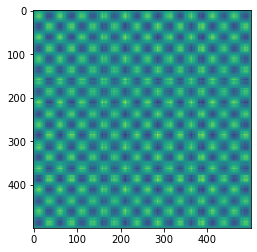

In [52]:
plt.imshow(cov_sample(X, 0))

In [6]:
np.diag(cov_sample(y, 0))

array([0.1194662 , 0.14310369, 0.49525899, 0.69761069, 0.55478148,
       1.03160276, 0.83988908, 1.40652015, 0.50813306, 0.19332702,
       0.51394601, 0.43726277, 0.28533465, 0.10302115, 0.09899146,
       0.43279105, 0.46164341, 0.88251565, 1.42004352, 1.23283698,
       1.05093101, 0.51960228, 0.33813545, 0.2868401 , 0.26374996,
       0.0526314 , 0.24646866, 0.78609595, 0.1640057 , 0.61264083,
       0.69784377, 0.67033897, 1.31115401, 0.74441069, 0.23623767,
       0.07021476, 0.24141171, 0.02898973, 0.04704284, 0.08495193,
       0.34156445, 1.01182052, 0.86088724, 0.33668062, 0.76182949,
       1.55328343, 0.88427212, 0.43675862, 0.06236416, 0.7192516 ,
       0.03571606, 0.15321902, 0.0462264 , 1.63002104, 0.91179398,
       0.56264551, 0.58832244, 0.5796378 , 0.70523984, 0.68798783,
       0.46693989, 0.06563805, 0.12947412, 0.05958306, 0.31320718,
       0.58268231, 0.35600744, 0.88851656, 0.59116603, 0.96689299,
       0.62619519, 0.5411681 , 0.35708156, 0.26486485, 0.04186

In [4]:
scipy.stats.spearmanr(x, y)

SpearmanrResult(correlation=0.9122995211980849, pvalue=3.2188991538610426e-195)

In [7]:
x.T * x

array([1.47101897e-02, 5.77317226e-04, 1.88482527e-03, 5.79076040e-01,
       7.50429323e-01, 1.18158356e+00, 1.84337623e+00, 1.03716895e+00,
       1.28696826e+00, 6.77170621e-01, 5.45365805e-01, 1.38070529e-01,
       1.82708739e-02, 1.05714841e-01, 1.51969821e-04, 5.18893404e-01,
       4.65403397e-01, 7.22137529e-01, 1.29788906e+00, 1.24098609e+00,
       6.20833559e-01, 9.54375797e-01, 4.63731325e-01, 4.19423424e-01,
       6.56909544e-04, 4.62476687e-02, 5.76933199e-02, 2.49446759e-01,
       2.97989939e-01, 2.50280063e-01, 7.99832347e-01, 7.70445918e-01,
       3.43303112e-01, 1.59553460e-01, 8.26112609e-01, 3.57016183e-01,
       1.39646717e-01, 3.68304108e-03, 4.96885142e-02, 4.95026069e-02,
       9.78343406e-02, 6.60177293e-01, 6.02882944e-01, 5.98935914e-01,
       1.00843119e+00, 6.05216630e-01, 8.59848639e-01, 3.77482651e-01,
       3.54662737e-01, 2.42804463e-03, 3.65248499e-03, 4.68346362e-02,
       3.35866604e-01, 6.11835790e-01, 7.75138396e-01, 6.42699268e-01,
      

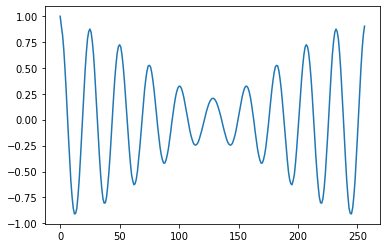

In [3]:
plt.plot(acf_welch(x))

In [8]:
len(1)

TypeError: object of type 'int' has no len()

In [4]:
np.fft.ifft


<function numpy.fft.ifft(a, n=None, axis=-1, norm=None)>